# Transformer学习

## 1. 理解Transformer模型

Transformer模型主要由以下几个部分组成：

- **输入嵌入（Input Embedding）**：将输入文本转换成固定大小的向量。
- **位置编码（Positional Encoding）**：为模型添加关于单词在句子中位置的信息。
- **多头自注意力机制（Multi-Head Self-Attention）**：允许模型同时关注句子中的不同部分。
- **前馈神经网络（Feed Forward Neural Network）**：在每个Transformer层中应用。
- **标准化层（Normalization Layer）**：用于稳定训练过程。
- **输出层（Output Layer）**：将Transformer层的输出转换为最终的输出格式。

## 2. 实现多头自注意力

多头自注意力是Transformer模型的核心。这个部分包括：

- **缩放点积注意力（Scaled Dot-Product Attention）**：计算键（K）、查询（Q）和值（V）之间的注意力。
- **多头机制**：将注意力分割成多个头，独立计算后再合并。

## 3. 构建Transformer层

每个Transformer层都包含一个多头自注意力子层和一个简单的前馈神经网络。这两个子层都有残差连接和标准化层。

## 4. 构建位置编码

位置编码是Transformer的一个关键部分，因为它给出了序列中每个元素的位置信息。通常，位置编码是通过正弦和余弦函数的组合来实现的。

## 5. 构建编码器和解码器

- **编码器**：包含N个相同的层，每层都有多头自注意力和前馈神经网络。
- **解码器**：也包含N个层，但每层有两个多头自注意力机制，一个是自注意力，另一个是编码器-解码器注意力，以及一个前馈神经网络。

## 6. 定义输出层

输出层通常是一个线性层，用于将解码器的输出转换为所需的格式，例如，用于文本生成或分类。

## 代码开始

（这里是否需要固定种子呢？）

In [11]:
import math
import os
import pickle
import random
import time
from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import jieba
from tqdm import tqdm
from pandarallel import pandarallel

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device is {device}, cuda_device_0:{torch.cuda.get_device_name(0)}')

# tqdm.pandas()
pandarallel.initialize(progress_bar=True)

device is cuda, cuda_device_0:NVIDIA GeForce RTX 4060 Ti
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## 数据预处理

使用pandas读取数据集，并输出基本情况

In [2]:
DATA_PATH = "./dataset/DMSC_2M.csv"
df1 = pd.read_csv(DATA_PATH)

In [3]:
print("总数:", len(df1))
print("每列包含的内容:", df1.columns.tolist())
print("缺失元素:", df1.isnull().sum().to_dict())
df1.head()

# 总数: 2125056
# 每列包含的内容: ['ID', 'Movie_Name_EN', 'Movie_Name_CN', 'Crawl_Date', 'Number', 'Username', 'Date', 'Star', 'Comment', 'Like']
# 缺失元素: {'ID': 0, 'Movie_Name_EN': 0, 'Movie_Name_CN': 0, 'Crawl_Date': 0, 'Number': 0, 'Username': 173, 'Date': 0, 'Star': 0, 'Comment': 0, 'Like': 0}

总数: 2125056
每列包含的内容: ['ID', 'Movie_Name_EN', 'Movie_Name_CN', 'Crawl_Date', 'Number', 'Username', 'Date', 'Star', 'Comment', 'Like']
缺失元素: {'ID': 0, 'Movie_Name_EN': 0, 'Movie_Name_CN': 0, 'Crawl_Date': 0, 'Number': 0, 'Username': 173, 'Date': 0, 'Star': 0, 'Comment': 0, 'Like': 0}


,ID,Movie_Name_EN,Movie_Name_CN,Crawl_Date,Number,Username,Date,Star,Comment,Like
0,0,Avengers Age of Ultron,复仇者联盟2,2017-01-22,1,然潘,2015-05-13,3,连奥创都知道整容要去韩国。,2404
1,1,Avengers Age of Ultron,复仇者联盟2,2017-01-22,2,更深的白色,2015-04-24,2,非常失望，剧本完全敷衍了事，主线剧情没突破大家可以理解，可所有的人物都缺乏动机，正邪之间、...,1231
2,2,Avengers Age of Ultron,复仇者联盟2,2017-01-22,3,有意识的贱民,2015-04-26,2,2015年度最失望作品。以为面面俱到，实则画蛇添足；以为主题深刻，实则老调重弹；以为推陈出...,1052
3,3,Avengers Age of Ultron,复仇者联盟2,2017-01-22,4,不老的李大爷耶,2015-04-23,4,《铁人2》中勾引钢铁侠，《妇联1》中勾引鹰眼，《美队2》中勾引美国队长，在《妇联2》中终于...,1045
4,4,Avengers Age of Ultron,复仇者联盟2,2017-01-22,5,ZephyrO,2015-04-22,2,虽然从头打到尾，但是真的很无聊啊。,723


In [4]:
DATA_PATH = "./dataset/DMSC_10M.csv"
df2 = pd.read_csv(DATA_PATH)

In [5]:
print("总数:", len(df2))
print("每列包含的内容:", df2.columns.tolist())
print("缺失元素:", df2.isnull().sum().to_dict())
df2.head()

# 总数: 10310989
# 每列包含的内容: ['ID', 'Movie_Name', 'Score', 'Review_People', 'Star_Distribution', 'Craw_Date', 'Username', 'Date', 'Star', 'Comment', 'Comment_Distribution', 'Like']
# 缺失元素: {'ID': 0, 'Movie_Name': 0, 'Score': 0, 'Review_People': 0, 'Star_Distribution': 0, 'Craw_Date': 0, 'Username': 1876, 'Date': 0, 'Star': 0, 'Comment': 7, 'Comment_Distribution': 0, 'Like': 0}

总数: 10310989
每列包含的内容: ['ID', 'Movie_Name', 'Score', 'Review_People', 'Star_Distribution', 'Craw_Date', 'Username', 'Date', 'Star', 'Comment', 'Comment_Distribution', 'Like']
缺失元素: {'ID': 0, 'Movie_Name': 0, 'Score': 0, 'Review_People': 0, 'Star_Distribution': 0, 'Craw_Date': 0, 'Username': 1876, 'Date': 0, 'Star': 0, 'Comment': 7, 'Comment_Distribution': 0, 'Like': 0}


,ID,Movie_Name,Score,Review_People,Star_Distribution,Craw_Date,Username,Date,Star,Comment,Comment_Distribution,Like
0,0,"1988年的妮可 Nico, 1988",7.5,565,15.2%48.2%32.3%3.4%0.8%,2019-10-05,尾黑,2018-06-23,3,成本低廉的PPT电影，用Nico生命中最后一年发生的事给Nico的歌配上情节，倒不算尴尬。女...,66%31%3%,4
1,1,"1988年的妮可 Nico, 1988",7.5,565,15.2%48.2%32.3%3.4%0.8%,2019-10-05,大奇特(Grinch),2018-06-28,3,传记片能做到半真半假的真实，就成功一半了，然后就是走进人物的内心世界。这部影片做到了纪录片般...,66%31%3%,4
2,2,"1988年的妮可 Nico, 1988",7.5,565,15.2%48.2%32.3%3.4%0.8%,2019-10-05,西楼尘,2018-07-01,3,意大利房东记得他的嚣张，岔开大腿抽着烟说，我的计划是成为优雅的老女人。总念错名字的劳拉记得她...,66%31%3%,2
3,3,"1988年的妮可 Nico, 1988",7.5,565,15.2%48.2%32.3%3.4%0.8%,2019-10-05,张晚禾,2018-06-28,3,意大利电影周开幕片,66%31%3%,0
4,4,"1988年的妮可 Nico, 1988",7.5,565,15.2%48.2%32.3%3.4%0.8%,2019-10-05,汪金卫,2018-06-29,3,【中国电影资料馆展映】歌星Nico的最后三年，青春不再，人气不再，衰老暴躁，在漂泊不定的巡回...,66%31%3%,1


In [6]:
combined_comment = pd.concat([df1["Comment"], df2["Comment"]])
combined_star = pd.concat([df1["Star"], df2["Star"]])

combined_df = pd.DataFrame({"Comment": combined_comment, "Star": combined_star}).dropna()
del df1, df2

combined_df_unique = combined_df.drop_duplicates().reset_index(drop=True) # 删除重复行，重置索引并覆盖原索引
print("总数:", len(combined_df_unique)) # 总数: 11494120
combined_df_unique.head()

总数: 11494120


### 绘制星级的分布条形图

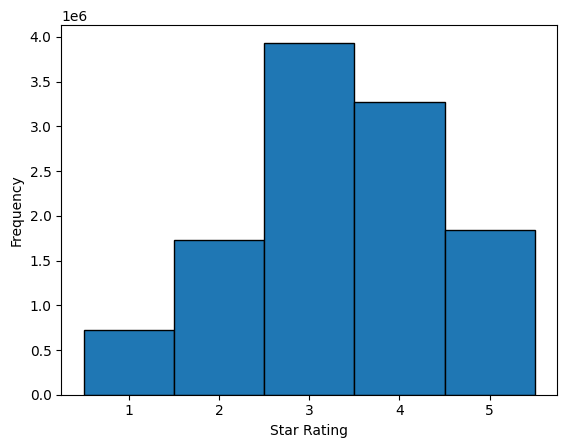

In [7]:
plt.hist(combined_df_unique['Star'], bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

### 创建词典

首先需要使用jieba库进行中文分词，并结合停用词表过滤不需要的词。

同时统一句子长度，超过指定值的截断，小于指定值的使用"\<pad\>"补全。

In [8]:
# 读取停用词表
stopwords_list_path = [
    "./stopwords/baidu_stopwords.txt",
    "./stopwords/cn_stopwords.txt",
    "./stopwords/hit_stopwords.txt",
    "./stopwords/scu_stopwords.txt",
]

def load_stopwords(paths:list[str]) -> set[str]:
    stopwords = []
    for path in paths:
        with open(path, "r", encoding="utf-8") as f_obj:
            stopwords += [line.strip() for line in f_obj]
            
    return set(stopwords)

stopwords = load_stopwords(stopwords_list_path)

In [9]:
# 使用jieba分词，可选用停用词表进行筛选
def tokenize_str(sentence:str, use_stopwords:bool=False) -> list[str]:
    seg_list = list(jieba.cut(sentence.strip(), cut_all=False))
    if use_stopwords == False:
        return seg_list
    
    filtered_words = [word for word in seg_list if word not in stopwords]
    return filtered_words

tokenize_str = partial(tokenize_str, use_stopwords=False) # 是否启用停用词表
tokenizer = get_tokenizer(tokenize_str)

start_time = time.perf_counter()
# tokenized = df['Comment'].progress_apply(tokenizer)
tokenized = combined_df_unique['Comment'].parallel_apply(tokenizer)
print(f"finished in {time.perf_counter() - start_time}s!")

tokenized.head()

Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.491 seconds.
Prefix dict has been built successfully.
Loading model cost 0.503 seconds.
Prefix dict has been built successfully.
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.497 seconds.
Prefix dict has been built successfully.
Loading model cost 0.515 seconds.
Dumping model to file cache /tmp/jieba.cache
Prefix dict has been built successfully.
Loading model cost 0.515 seconds.
Prefix dict has been built successfully.
Loading model cost 0.517 seconds.
Pre

finished in 441.174844284s!


0                      [连, 奥创, 都, 知道, 整容, 要, 去, 韩国, 。]
1    [非常, 失望, ，, 剧本, 完全, 敷衍了事, ，, 主线, 剧情, 没, 突破, 大家...
2    [2015, 年度, 最, 失望, 作品, 。, 以为, 面面俱到, ，, 实则, 画蛇添足...
3    [《, 铁人, 2, 》, 中, 勾引, 钢铁, 侠, ，, 《, 妇联, 1, 》, 中,...
4              [虽然, 从头, 打到, 尾, ，, 但是, 真的, 很, 无聊, 啊, 。]
Name: Comment, dtype: object

In [10]:
# 构建词汇表
vocab = build_vocab_from_iterator(tokenized, min_freq=2, specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"]) # 将不在词汇表中的词语设置为"<unk>"
print(f"vocab len:{len(vocab)}")

vocab len:578378


In [ ]:
with open('./12M_vocab_freq2.pkl', 'wb') as f:
    pickle.dump(vocab, f)

### 统一句子长度

绘制电影评论长度分布图像，用于之后进行pad_sequence统一句子长度时参考

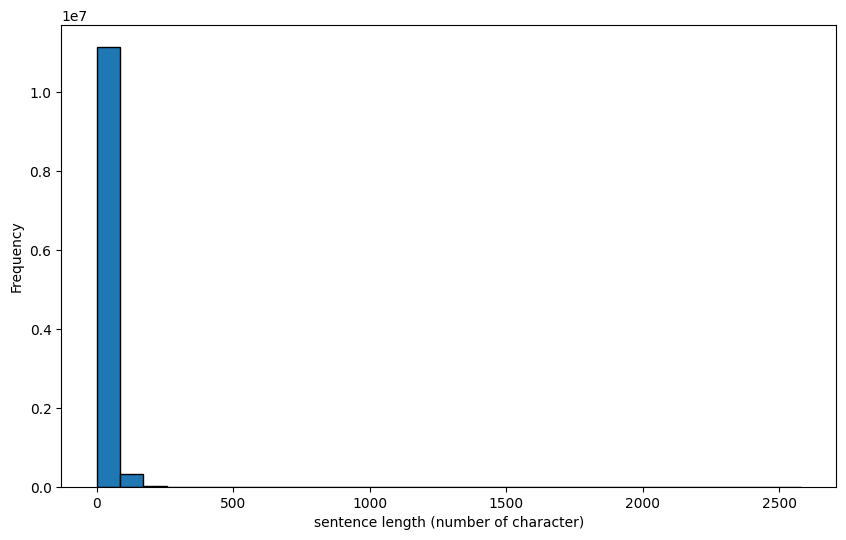

In [12]:
df_length = tokenized.apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df_length, bins=30, edgecolor='black')
plt.xlabel('sentence length (number of character)')
plt.ylabel('Frequency')
plt.show()

In [16]:
filtered_df = tokenized[df_length < 64]
num_sentences_less_than = filtered_df.shape[0]
print(num_sentences_less_than, f'{num_sentences_less_than / len(tokenized) * 100}%')
# 长度小于64的评论有10494859条，占比91.31%

10494859 91.30632880116094%


In [ ]:
# 统一句子长度
indexed_sequences = [torch.tensor([vocab[token] for token in seq]) for seq in tokenized]
padded_sequences = pad_sequence(indexed_sequences, batch_first=True, padding_value=vocab['<pad>'])
target_length = 64
padded_sequences = padded_sequences[:, :target_length]

print(tokenized[:5], len(tokenized))
print(padded_sequences[:5], len(padded_sequences))

### 创建Dataset和DataLoader

将前面的数据预处理部分放入Dataset，1-2星为负面，3星中性，4-5星正面

In [33]:
class CommentSet(Dataset):
    def __init__(self, Comments:torch.Tensor, Stars:pd.Series) -> None:
        assert Stars.min() >= 1 and Stars.max() <= 5, "Label out of range"
        assert len(Comments) == len(Stars), "The number of comments and stars is not the same!"
        self.Comments = Comments.long()
        self.Stars = torch.tensor(Stars, dtype=torch.long)
        
    def __len__(self):
        return len(self.Comments)

    def __getitem__(self, idx:int) -> tuple:
        star = self.Stars[idx] - 1
        # assert 0 <= star < 5, "The converted label is out of range"
        if star <= 2:  # 1 and 2 stars are considered negative reviews
            label = 0
        elif star == 3:  # 3 stars are considered neutral reviews
            label = 1
        else:  # 4 and 5 stars are considered positive reviews
            label = 2
        return self.Comments[idx], label
    
comment_set = CommentSet(padded_sequences, df["Star"])

In [34]:
# 创建DataLoader
data_loader = DataLoader(comment_set, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)
comment, star = next(iter(data_loader))
print(comment, comment.dtype)
print(star, star.dtype)
print(len(comment), len(star))

tensor([[32414,  1343,  1521,  ...,     1,     1,     1],
        [ 4437,   165,  1024,  ...,     1,     1,     1],
        [ 3023,   900,   197,  ...,     1,     1,     1],
        ...,
        [   12,   521,   130,  ...,     1,     1,     1],
        [  540,   424,     1,  ...,     1,     1,     1],
        [    5,    13,  1219,  ...,     1,     1,     1]]) torch.int64
tensor([3, 4, 3, 0, 4, 1, 3, 4, 0, 4, 2, 3, 4, 1, 4, 3, 1, 2, 3, 4, 2, 3, 2, 3,
        4, 4, 4, 3, 4, 3, 3, 4, 3, 1, 2, 4, 2, 3, 2, 1, 3, 2, 2, 3, 2, 2, 3, 0,
        0, 2, 3, 3, 4, 3, 1, 3, 4, 4, 0, 2, 2, 4, 4, 2, 3, 0, 0, 3, 3, 3, 0, 4,
        4, 2, 3, 0, 2, 0, 3, 3, 4, 1, 0, 2, 2, 3, 4, 3, 3, 2, 0, 3, 3, 4, 4, 2,
        4, 4, 3, 0, 3, 0, 2, 4, 4, 2, 1, 4, 0, 1, 3, 4, 2, 2, 2, 0, 4, 4, 4, 2,
        2, 2, 3, 1, 4, 0, 2, 1]) torch.int64
128 128


## 模型构造

<img src="./images/transformer.png" title="transformer" width="600" alt="transformer基本架构 图片来自论文https://arxiv.org/abs/2106.04554">
<p>transformer基本架构</p>

图片来自论文：https://arxiv.org/abs/2106.04554

讲解视频：https://www.bilibili.com/video/BV1cP4y1V7GF/

大致分为几部分：
* 词嵌入
* 位置编码
* 多头注意力
    * 多头机制
    * 缩放点积自注意力(Scaled Dot-Product Attention)
    * 带掩码的多头注意力(mask)
* 编码器和解码器
    * 基于位置的前馈神经网络 (Position-Wise Feed-Forward Network)    
    * 多头注意力    
    * Add & Norm
    
***注***：在transformer模型中，模型维度d_model一般指的是词嵌入维度

In [35]:
# 模型超参数
batch_size = 128
max_len = 32
d_model = 512
num_heads = 8
d_ff = 2048
n_layers = 6
d_k = d_model // num_heads

### 词嵌入

使用pytorch自带的nn.Embedding()层

* 官方文档：https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

在 PyTorch 中，`torch.nn.Embedding` 类是一个用于存储固定字典和大小的嵌入（embeddings）的简单查找表。这个模块通常用于存储单词嵌入，并使用索引来检索它们。该模块的输入是索引列表，输出是相应的单词嵌入。

| 参数名称 | 类型 | 描述 |
|----------|------|------|
| num_embeddings | int | 嵌入字典的大小 |
| embedding_dim | int | 每个嵌入向量的维度大小 |
| padding_idx | int, 可选 | 如果指定，padding_idx 的条目不会对梯度产生影响；因此，训练期间 padding_idx 的嵌入向量不会更新，即它保持为固定的“填充”（默认为全零，但可以更新为其他值） |
| max_norm | float, 可选 | 如果给定，每个嵌入向量的范数大于 max_norm 时，会被重新标准化为 max_norm |
| norm_type | float, 可选 | 用于 max_norm 选项的 p-范数的 p 值（默认为2） |
| scale_grad_by_freq | bool, 可选 | 如果给定，将通过单词在小批量中的频率的逆来缩放梯度（默认为 False） |
| sparse | bool, 可选 | 如果为 True，权重矩阵相对的梯度将是一个稀疏张量（参见备注了解有关稀疏梯度的更多细节） |

变量：
- weight (Tensor)：模块的可学习权重，形状为 (num_embeddings, embedding_dim)，从 N(0,1) 分布初始化。

In [36]:
embedding_dim = d_model
embedding = nn.Embedding(len(vocab), embedding_dim)
comment, star = next(iter(data_loader))
print(comment, comment.shape)

em_result = embedding(comment)
print(em_result, em_result.shape)

tensor([[  99,    1,    1,  ...,    1,    1,    1],
        [1057,    0, 6747,  ...,    1,    1,    1],
        [  87,  884,  102,  ...,    1,    1,    1],
        ...,
        [1280,  142,    1,  ...,    1,    1,    1],
        [1585,   54, 2702,  ...,    1,    1,    1],
        [4307, 2055, 2886,  ..., 5798,   17,  207]]) torch.Size([128, 32])
tensor([[[ 0.1671, -0.5303,  0.2925,  ...,  0.4999, -0.9852, -1.0923],
         [ 0.2681, -1.0434,  1.6845,  ...,  0.2032, -0.1511,  0.5267],
         [ 0.2681, -1.0434,  1.6845,  ...,  0.2032, -0.1511,  0.5267],
         ...,
         [ 0.2681, -1.0434,  1.6845,  ...,  0.2032, -0.1511,  0.5267],
         [ 0.2681, -1.0434,  1.6845,  ...,  0.2032, -0.1511,  0.5267],
         [ 0.2681, -1.0434,  1.6845,  ...,  0.2032, -0.1511,  0.5267]],

        [[ 1.5045, -0.1059, -1.2406,  ..., -1.2170, -0.5601, -0.7029],
         [-0.1495, -0.1070,  0.3412,  ..., -1.6158, -0.3277,  1.9798],
         [ 0.0872,  0.5031,  0.6048,  ..., -0.7230, -1.6140, -1.0487

### 位置编码

参考资料：https://blog.csdn.net/m0_37605642/article/details/132866365

#### 为什么需要位置编码

1. **捕捉序列顺序信息**：Transformer模型本身通过自注意力机制处理输入，但这种机制本质上是顺序不变的（sequence-agnostic）。也就是说，如果没有额外的信息，模型无法区分词序。位置编码的引入就是为了提供这种序列中词的相对或绝对位置信息。

2. **区分相同词汇在不同位置的语义**：在语言中，相同的词汇在不同的位置可能具有不同的含义或重要性。位置编码帮助模型理解这种区别。

#### 位置编码的原理

理想的位置编码应该满足：

* 为每个字输出唯一的编码；
* 不同长度的句子之间，任何两个字之间的差值应该保持一致；
* 编码值应该是有界的。

使用正余弦函数这样的周期函数可以很好地满足上面的要求：

* 一个词语的位置编码是由不同频率的余弦函数组成的，从低位到高位，余弦函数对应的频率由$1$降低到 $\frac{1}{10000}$，波长从 $2\pi$ 增加到 $10000\cdot2\pi$

$$PE_{(pos,2i)} = \sin\Bigg(\frac{pos}{10000^{2i/d_{\text{model}}}}\Bigg)$$

$$PE_{(pos,2i+1)} = \cos\Bigg(\frac{pos}{10000^{2i/d_{\text{model}}}}\Bigg)$$

* 所以需要生成的位置编码的矩阵为$[sentence\_len, d_{model}]$，第一个维度为最大句子长度，第二个维度为词嵌入模型的维度

* $pos = 0, 1, ..., N - 1$，$i = 0, 1, ..., \frac{d_{model}}{2} - 1$。简单来说就是pos和句子长度相关，每个位置的词都有$d_{model}$个正余弦函数，奇数行为正弦，偶数行为余弦

* 输入经过embedding后的结果$X$，输出添加位置信息后的结果$X + PE$。

#### 代码说明

参考OpenNMT中的代码实现

```python
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]
```

`pe`：该矩阵为全为0的，形状为$[max\_len, d\_model]$的张量，会在之后进行处理。

`position`：生成值为$[0, max\_len)$的序列，并且添加一个维度，将其从一维$[max\_len]$的形状变为二维$[1, max\_len]$。

`div_term`：`torch.arange(0, d_model, 2)`先生成值为$[0, d\_model), step=2$，形状为$[\frac{d\_model}{2}]$的张量，然后进行下一步处理。

`-math.log(10000.0)`：为了在代码中简化计算，可以只计算 $\ln{(10000)}$ 的一部分，并且用负号来处理指数的递减特性（原公式中是除以这个指数，而在代码中是乘以它）。因此，$-\ln{(10000)}$ 就是为了在代码实现中简化和直接应用 $10000^{2i/d\_model}$ 的计算。由于这个负号，值不相同但性质相同，$div\_term$也可以实现和$\frac{1}{10000^{2i/d\_model}}$一样的效果，随着$2i$增加而递减。

In [37]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len:int, embed_dim:int, dropout:float=0.1) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # 分子部分，生成[0, max_len)的序列，并且添加一个维度
        _2i = torch.arange(0, embed_dim, step=2).float() # 生成_2序列
        
        # 奇数列为正弦，偶数列为余弦
        pe[:, 0::2] = torch.sin(position / (10000 ** (_2i / embed_dim)))
        pe[:, 1::2] = torch.cos(position / (10000 ** (_2i / embed_dim)))
        
        # 将位置编码矩阵 pe 注册为一个 buffer，被认为是持久的值，不会作为模型参数，可添加到gpu中
        self.register_buffer('pe', pe)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        # x形状为[btach_size, sentence_len, embed_dim]，x.size(1)为句子长度，即位置编码张量的句子长度应该大于等于输入的句子长度，也是pos的范围
        # print(f'x:{x.shape}, self.pe:{self.pe.shape}')
        x = x + self.pe[:x.size(1), :]
        return self.dropout(x)
        

pe_layer = PositionalEncoding(max_len, embedding_dim)
pe_result = pe_layer(em_result)
print(pe_result, pe_result.shape)

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
tensor([[[ 0.1856,  0.5218,  0.3250,  ...,  1.6666, -1.0947, -0.1025],
         [ 1.2329, -0.5590,  2.7849,  ...,  1.3369, -0.1678,  1.6963],
         [ 1.3083, -1.6218,  2.9121,  ...,  1.3369, -0.1677,  1.6963],
         ...,
         [-0.4394, -0.0000,  2.1991,  ...,  1.3369, -0.1646,  1.6963],
         [-0.7999, -0.9880,  1.1856,  ...,  0.0000, -0.1645,  1.6963],
         [-0.1510, -0.1430,  0.7625,  ...,  1.3369, -0.0000,  1.6963]],

        [[ 1.6716,  0.9935, -1.3784,  ..., -0.2411, -0.6224,  0.3301],
         [ 0.7689,  0.4814,  1.2923,  ..., -0.6842, -0.3640,  3.3109],
         [ 0.0000,  0.0966,  1.7125,  ...,  0.3078, -1.7931, -0.0541],
         ...,
         [-0.4394, -1.9905,  2.1991,  ...,  1.3369, -0.1646,  1.6963],
         [-0.7999, -0.9880,  1.1856,  ...,  1.3369, -0.1645,  1.6963],
         [-0.1510, -0.0000,  0.7625,  ...,  1.3369, -0.1644,  1.6963]],

        [[ 0.1804,  1.2016,  0.2966,  ...,  1.1640,  1.5

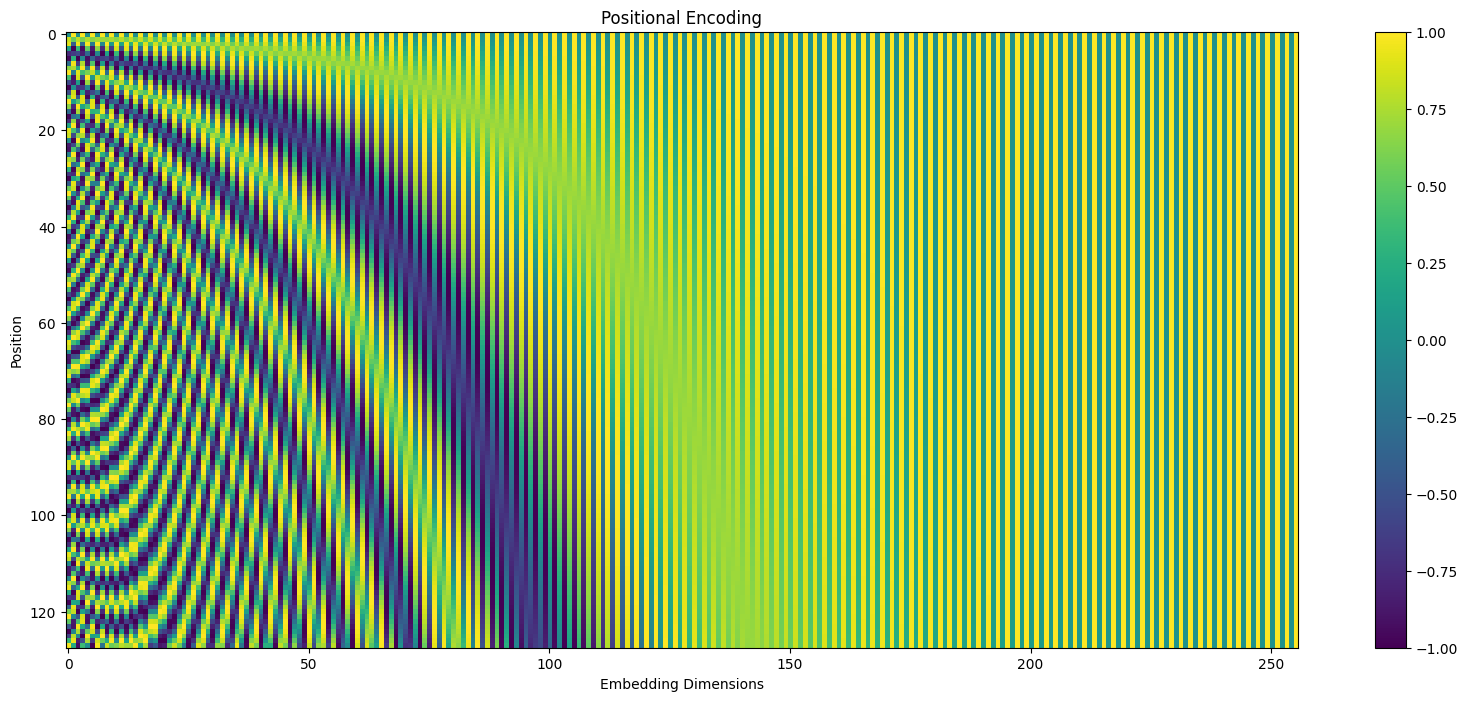

In [38]:
# 绘制位置编码图像
_max_len = 128
_embed_dim = 256
_pos_encoding = PositionalEncoding(_max_len, _embed_dim, dropout=0)
_pe = _pos_encoding.pe.squeeze(0)

plt.figure(figsize=(20, 8))
plt.imshow(_pe)
plt.colorbar()
plt.title("Positional Encoding")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Position")
plt.show()

### 注意力机制

<img src="./images/Scaled Dot-Product Attention.png" title="Scaled Dot-Product Attention" width="300" alt="Scaled Dot-Product Attention 图片来自论文https://arxiv.org/abs/1706.03762">
<p>Scaled Dot-Product Attention</p>

图片来自论文https://arxiv.org/abs/1706.03762

参考文章：

* https://jalammar.github.io/illustrated-transformer/

* https://www.zhihu.com/tardis/zm/art/414084879

#### Scaled Dot-Product Attention

Scaled Dot-Product Attention 是 Transformer 模型中自注意力机制的核心组成部分。这种注意力机制是通过计算查询（Queries）、键（Keys）和值（Values）之间的关系来实现的。它的基本思想是，对于每个查询，计算它与所有键的点积，然后对这些点积应用一个缩放因子，接着使用 softmax 函数来获取权重分布，最后用这些权重来加权对应的值。

#### 自注意力的特点

- **同一输入**：在自注意力中，查询（Q）、键（K）和值（V）都来自于同一个输入（例如，同一句话中的不同词汇）。
- **序列内关联**：自注意力关注输入序列内部的关联，即一个元素如何与序列中的其他元素相关联。

#### 举例

假设有一个简单的句子 "Thinking machines"。在自注意力机制中，"Thinking" 和 "machines" 同时作为查询、键和值。模型将计算 "Thinking" 与 "Thinking" 和 "machines" 的关联，以及 "machines" 与 "Thinking" 和 "machines" 的关联。通过这种方式，模型能够捕捉序列中不同元素之间的关系。

#### 查询（Queries）、键（Keys）和值（Values）

1. **查询（Queries）**：
   - 代表当前正在处理的目标元素。
   - 在自注意力中，每个序列中的元素都会被当作查询来考察与其他元素的关系。

2. **键（Keys）**：
   - 与查询配对，用于计算注意力得分。
   - 在自注意力中，序列中的每个元素都会被转换成一个键，与每个查询配对，以评估它们之间的关联程度。

3. **值（Values）**：
   - 与键相关联的实际内容。
   - 在自注意力中，序列中的每个元素也会被转换成一个值。注意力得分用于加权这些值，得到加权的输出，这些输出反映了输入序列中元素的聚合信息。

#### Scaled Dot-Product Attention 的计算过程

**公式表示**：$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_{model}}}\right)V$$
其中，$Q$, $K$, $V$ 分别是查询、键和值的矩阵，$d_{model}$ 是键向量的维度。

1. 点积注意力计算

- 首先，计算每个查询与所有键的点积。这个操作实际上在评估每个查询与每个键之间的相似度或关联程度。注意力分数的计算公式为：$$\text{Attention Score}(Q, K)=\frac{QK^T}{\sqrt{d_{model}}}$$

2. 缩放

- 点积通常会随着维度的增加而变大，可能导致 softmax 函数进入梯度较小的区域，从而影响模型学习效率。
- 为了缓解这个问题，将点积的结果除以$\sqrt{d_{model}}$（即键向量维度的平方根）进行缩放。

3. 应用 Softmax

- 使用 softmax 函数将缩放后的点积转换为概率分布。这一步骤确保了输出的注意力得分总和为 1，即将注意力分布在不同的键上。

4. 加权和

- 将 softmax 得分应用于值，得到加权和。这样，每个查询的输出都是值的加权组合，其中的权重反映了输入序列中不同元素对当前查询元素的重要性。

在 Scaled Dot-Product Attention 中，查询、键和值共同协作，使模型能够专注于输入序列中与当前元素最相关的部分。通过这种方式，模型能够捕捉序列内部的复杂依赖关系，无论这些依赖是长期的还是短期的。这种注意力机制是 Transformer 强大性能的关键，使其在处理各种序列数据（如自然语言、音频信号等）时表现出色。

#### 代码说明

* $Q$、$K$、$V$的转换通常是在 Transformer 模型的编码器或解码器层中进行的，而不是直接在自注意力机制内部。这是因为自注意力层通常被设计为一个更通用的模块，可以接受已经转换好的$Q$、$K$、$V$作为输入。

* 在解码器中，存在mask掩码，是为了控制或限制某些元素在注意力机制计算中的影响。掩码通常用于实现以下目的：
    1. **屏蔽无关的或非法的位置**：
        - 在处理带有填充（padding）的序列时，掩码用于确保模型在注意力计算中不考虑填充位置（`[PAD]`）。
    2. **实现因果关系（Causal）或顺序遮蔽**：
        - 在一些任务中，如语言模型训练，当前词汇的预测只应依赖于前面的词汇（而不是后面的），以保持信息流的单向性。只有该位置之前的位置（包括当前位置）被考虑，而之后的位置被掩蔽掉。
    3. **掩码的技术实现**
        - 掩码一般是一个与注意力得分矩阵形状相同的张量，其中要被忽略的位置上的值设为负无穷（或非常小的值），而其余位置上的值设为 0。
        - 当这个掩码加到未经 softmax 的注意力得分上时，被掩蔽的位置上的得分变得非常小（接近于负无穷），因此在经过 softmax 后，这些位置的注意力权重（即概率）变为接近于零，从而在注意力加权和计算中不起作用。

* 在多头注意力机制中，$d_{model}$ 会被分割成多个较小的部分，每个部分对应一个“头”。例如，如果 $d_{model} = 512$ 且使用了 8 个头，那么每个头处理的维度就是 64。这些小的头独立工作，最后其输出通常会被连接起来，再通过一个线性层，使其维度恢复为$d_{model}$。

* 维度变化：
    1. **输入嵌入**
        - 形状：`[batch_size, seq_length, d_model]`
    2. **通过线性层生成 Q, K, V**
        - Q, K, V 形状：`[batch_size, seq_length, d_model]`
    3. **应用多头注意力**
        - 分割 Q, K, V 为多个头
        - 每个头的 Q, K, V 形状：`[batch_size, seq_length, d_k]` 
         (其中 `d_k = d_model / num_heads`)
    4. **计算 Scores**
        - 执行 `matmul(Q, K.transpose(-2, -1))`
        - Scores 形状：`[batch_size, seq_length, seq_length]`
    5. **应用 Scores 到 V**
        - 执行 `matmul(Scores, V)`
        - 输出形状：`[batch_size, seq_length, d_k]`
    6. **合并多头输出并通过线性层**
        - 合并后形状：`[batch_size, seq_length, d_model]`


In [39]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_k:int, dropout:float=0.1) -> None:
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = dim_k
        self.sqrt_dk = torch.sqrt(torch.tensor(dim_k, dtype=torch.float32))
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor, mask:torch.Tensor=None) -> (torch.Tensor, torch.Tensor):
        # q和k维度相同，所以需要将k转置一下
        scores = torch.matmul(query, key.transpose(-2, -1)) / self.sqrt_dk
        
        if mask is not None: # 不直接if mask是为了避免张量全为0而跳过掩码处理的可能
            scores = scores.masked_fill(mask == 0, torch.finfo(scores.dtype).min) # torch.finfo(scores.dtype).min是dtype类型的最小值
            
        # 计算 softmax 得到注意力权重
        attention = self.softmax(scores)
        attention = self.dropout(attention)
        output = torch.matmul(attention, value)
        
        return output, attention
    

# 生成随机值进行测试
sdpa_layer = ScaledDotProductAttention(d_model)
Q = torch.randn(batch_size, max_len, d_model)
K = torch.randn(batch_size, max_len, d_model)
V = torch.randn(batch_size, max_len, d_model)

# 假设全为 1，表示没有掩码
mask = torch.ones(batch_size, max_len, max_len)

# 测试 ScaledDotProductAttention 层
output, attention = sdpa_layer(Q, K, V, mask)

print("Output Shape:", output.shape)
print("Attention Shape:", attention.shape)

Output Shape: torch.Size([128, 32, 512])
Attention Shape: torch.Size([128, 32, 32])


### Mask

在Transformer模型中，编码器（Encoder）和解码器（Decoder）使用掩码（mask）的目的和方式有所不同。

#### 编码器中的掩码

在编码器中，掩码主要用于屏蔽（masking）掉填充（padding）部分的影响。由于在处理自然语言数据时，不同的句子或文本序列往往长度不一，因此常常需要在较短的句子末尾添加填充标记，以使所有输入序列的长度一致。

- **目的**：避免模型在自注意力计算中考虑填充的部分，因为这些部分是无意义的，并不属于原始输入序列的一部分。
- **实现**：通常，编码器的掩码是一个二维的布尔张量（或等效的实现），其中填充位置被标记为`True`（或一个非常大的负数，以便在应用softmax时接近于零）。这个掩码被用于修改自注意力层的注意力分数，使得模型不会将注意力放在填充的词上。

#### 解码器中的掩码

解码器中的掩码有两种：一种是类似于编码器中的填充掩码，另一种是查找掩码（look-ahead mask，也称为因果掩码或解码器自注意力掩码）。

1. **填充掩码**：
   - 与编码器中的填充掩码类似，用于屏蔽掉填充部分的影响。

2. **查找掩码**：
   - **目的**：在训练阶段，防止解码器的自注意力层“偷看”未来的词。在自然语言处理的序列生成任务中，模型在生成当前词时应该只能依赖于之前的词。
   - **实现**：通过一个三角形的掩码（上三角为`True`或一个非常大的负数），确保在计算自注意力时，每个词只能与它之前的词（包括自己）进行交互，而不能与之后的词进行交互。

#### 情感分析任务的mask

* 情感分析任务为分类任务，输出为1-5的评分，所以仅仅需要encoder的mask

In [40]:
def create_padding_mask(seq_q:torch.Tensor, seq_k:torch.Tensor, pad_idx:int) -> torch.Tensor:
    """ 创建注意力掩码以识别序列中的<pad>占位符
    Args:
        seq_q (Tensor): query序列，shape = [batch size, query len]
        seq_k (Tensor): key序列，shape = [batch size, key len]
        pad_idx (int): key序列<pad>占位符对应的数字索引
    """
    # 创建一个掩码，其中seq_k等于pad_idx的位置为True
    pad_attn_mask = (seq_k == pad_idx)

    # 调整掩码的形状以匹配注意力权重矩阵的形状
    pad_attn_mask = pad_attn_mask.unsqueeze(1).expand(-1, seq_q.size(1), -1)

    return pad_attn_mask == False

temp = comment[0].unsqueeze(0)
print(temp, temp.shape)
temp_mask_result = create_padding_mask(temp, temp, pad_idx=vocab['<pad>'])
print(temp_mask_result, temp_mask_result.shape)
print(temp_mask_result[0][0])

tensor([[99,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]]) torch.Size([1, 32])
tensor([[[ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         ...,
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False],
         [ True, False, False,  ..., False, False, False]]]) torch.Size([1, 32, 32])
tensor([ True, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False])


### 多头注意力(Multi-Head Attention)

多头注意力（Multi-Head Attention）是 Transformer 模型中的一个核心组件，它允许模型在不同的表示子空间中并行地关注输入序列的不同部分。这种机制提高了模型捕获各种不同特征的能力，从而增强了整体性能。

#### 多头注意力的工作原理

多头注意力的关键在于将原始的注意力机制（如缩放点积注意力）分割成多个头部（head），每个头部独立地进行注意力计算。这样做的优势在于：

1. **多角度学习**：每个头部可以从不同的角度学习输入数据的特征，捕捉不同层次的信息。
2. **并行处理**：所有的头部可以并行地执行，提高计算效率。
3. **增强表达能力**：通过将多个头部的结果组合起来，模型可以获得更丰富、更综合的信息表示。

#### 多头注意力的实现

每个头部独立执行以下操作：

1. **线性映射**：输入的 Q（查询），K（键）和 V（值）通过不同的线性层（权重矩阵 $W^Q_i$、$W^K_i$ 和 $W^V_i$）映射到不同的子空间。
   
   $$
   \text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i) = \text{softmax}\left(\frac{QW^Q_i (KW^K_i)^T}{\sqrt{d_{k}}}\right)VW^V_i
   $$
   
   其中，$W^Q_i \in \mathbb{R}^{d_{model}\times d_{k}}$、$W^K_i \in \mathbb{R}^{d_{model}\times d_{k}}$ 和 $W^V_i \in \mathbb{R}^{d_{model}\times d_{v}}$ 是可学习的权重参数。一般来说，$d_k = d_v = d_{model} / n_{head}$。

2. **计算自注意力**：在每个子空间内，独立计算自注意力分数和输出。

3. **合并头部输出**：将所有头部的输出拼接到一起，并通过另一个线性层 $W^O$ 映射回原始维度。
   
   $$
   \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O
   $$
   
#### 代码说明

- `batch_size`: 批次大小
- `max_len`: 序列长度
- `d_model`: 模型维度
- `num_heads`: 注意力头数
- `d_k`: 每个头的维度，这里是 `d_model / num_heads`

1. **输入嵌入 (Embedding Input):**
    - 形状：`[batch_size, max_len, d_model]`
2. **通过线性层生成 Q, K, V (Linear Transformation for Q, K, V):**
    - 对于Q, K, V，每个的形状在通过`W_q`, `W_k`, `W_v`后保持不变：`[batch_size, max_len, d_model]`
3. **应用多头注意力 (Applying Multi-Head Attention):**
    - 分割Q, K, V为多个头，每个头的维度为`d_k`，`[batch_size, max_len, num_heads, d_k]`
    - transpose后每个头的Q, K, V形状：`[batch_size, num_heads, max_len, d_k]`
    - mask维度为`[batch_size, max_len, max_len]`，经过unsqueeze后变为`[batch_size, 1, max_len, max_len]`，expand后变为`[batch_size, num_heads, max_len, max_len]`
    - 返回的矩阵形状为`[batch_size, num_heads, max_len, d_k]`
4. **合并多头输出并通过线性层 (Concatenating and Linear Transformation):**
    - transpose后的维度为`[batch_size, max_len, num_heads, d_k]`
    - contiguous()类似深拷贝，transpose并不会生成新的张量，修改会修改到原变量
    - 经过view(batch_size, -1, self.d_model)后： 维度变为`[batch_size, seq_length, d_model]`
    - 合并后的形状：`[batch_size, max_len, num_heads * d_k]`，然后通过`W_o`恢复到`[batch_size, max_len, d_model]`

In [41]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model:int, num_heads:int, dropout:float=0.1):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.attention = ScaledDotProductAttention(self.d_k, dropout=dropout)

        # 定义线性层
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)


    def forward(self, query:torch.Tensor, key:torch.Tensor, value:torch.Tensor, mask:torch.Tensor) -> (torch.Tensor, torch.Tensor):
        # Q K V的形状为[batch_size, seq_len, d_model]
        batch_size = query.size(0)
        seq_len = query.size(1)

        query = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 计算多头注意力
        mask = mask.unsqueeze(1)  # 添加一个维度
        mask = mask.expand(batch_size, self.num_heads, seq_len, seq_len)  # 扩展mask以匹配多头注意力
        output, attention = self.attention(query, key, value, mask)

        # 拼接头部并应用最终线性层
        # contiguous()类似深拷贝，transpose并不会生成新的张量，修改会修改到原变量
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attention
    

ma_layer = MultiHeadAttention(d_model, num_heads)
output, attention = ma_layer(Q, K, V, mask)
print("Output Shape:", output.shape)
print("Attention Shape:", attention.shape)

Output Shape: torch.Size([128, 32, 512])
Attention Shape: torch.Size([128, 8, 32, 32])


### 基于位置的前馈神经网络（Position-Wise Feed-Forward Network）

PFF网络包含以下主要组成部分：

$$\mathrm{FFN}(x) = \mathrm{ReLU}(xW_1 + b_1)W_2 + b_2$$

1. **两个线性层**：它们是全连接层，作用是对输入数据进行线性变换。
2. **激活函数**：通常在这两个线性层之间。常用的激活函数是ReLU（Rectified Linear Unit）或GELU（Gaussian Error Linear Unit）。激活函数的作用是引入非线性，使模型能够学习到更复杂的特征。
3. **Dropout**：可选的，用于减少过拟合。

#### PFF网络的作用

1. **非线性变换**：虽然Transformer的注意力机制非常强大，但它本质上是一种线性操作。PFF网络通过引入非线性激活函数，使模型能够学习更复杂的特征表示。
2. **增加模型容量**：PFF网络通过增加参数数量，增加了模型的容量。这使得模型能够学习更多的特征，并提高了其在复杂任务上的性能。
3. **独立处理每个位置**：PFF网络对序列中的每个位置独立地应用相同的操作，这有助于保持模型对输入顺序的敏感度。

#### 代码说明

- `d_model` 是输入和输出的维度，通常与Transformer模型中的嵌入维度相同。
- `d_ff` 是内部层的维度，它通常大于`d_model`，以便在网络中引入更多的参数和非线性。
- 使用ReLU作为激活函数。
- 在两个线性层之间应用了激活函数和dropout。

In [42]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model:int, d_ff:int, dropout:float=0.1) -> None:
        super(PositionWiseFeedForward, self).__init__()
        self.FFN = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        
    def forward(self, X:torch.Tensor) -> torch.Tensor:
        return self.FFN(X)
    
    
pwff_layer = PositionWiseFeedForward(d_model, 2048)
pwff_result = pwff_layer(pe_result)
print(pwff_result.shape)

torch.Size([128, 32, 512])


### Add & Norm

包含两个主要部分：残差连接（Add）和层归一化（Norm）。这一步骤出现在自注意力（Self-Attention）和前馈全连接网络（Pointwise Feedforward Network）的每一个模块之后。

1. **残差连接（Add）**
   - **快速训练**：残差连接帮助解决了深度网络中的梯度消失问题，使得更深的网络能够更有效地训练。
   - **信息保持**：它允许模型在每一层中保持输入信息的一部分，从而提高了信息流动和网络的学习能力。

2. **层归一化（Norm）**
   - **稳定训练**：归一化过程可以稳定训练过程，使得各层的学习速率相近，避免某些层过快或过慢地学习。
   - **加快收敛**：通过规范化输入，层归一化有助于加快模型的收敛速度。

#### 处理过程

在每个自注意力和前馈全连接网络模块后，都会有一个Add & Norm步骤。处理过程可以描述如下：

1. **残差连接（Add）**：
   - 输入通过自注意力或前馈全连接网络得到输出。
   - 将此输出与相应模块的原始输入相加（残差连接）。
   - 公式：$\text{Output}_{\text{residual}} = \text{Input} + \text{Sublayer}(\text{Input})$
     其中，Sublayer表示自注意力或前馈全连接网络。
2. **层归一化（Norm）**：
   - 对残差连接的结果进行层归一化。
   - 公式：$\text{Output}_{\text{norm}} = \text{LayerNorm}(\text{Output}_{\text{residual}})$
     层归一化公式是：$\text{LayerNorm}(x) = \gamma \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$
     其中，$\mu$和$\sigma^2$分别是输入x的均值和方差，$\gamma$和$\beta$是可学习的参数，$\epsilon$是一个很小的数，防止除以0。
     
####  代码说明

* 通过transformer encoder的流程图可以看到，第一个Add&Norm部分的子层即为嵌入后的输入，第二个Add&Norm部分的子层为第一个Add&Norm的输出。`MultiHeadAttention`和`PoswiseFeedForward`是专门为Transformer设计的复杂子层。

In [43]:
class AddNorm(nn.Module):
    def __init__(self, size:int, dropout:float=0.1) -> None:
        super(AddNorm, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x:torch.Tensor, sublayer:torch.Tensor) -> torch.Tensor:
        # print(f'x:{x.shape}, sublayer:{sublayer.shape}')
        return self.norm(self.dropout(x) + sublayer)

### Encoder Layer

通过以上的组件，已经可以实现编码器的一个层了

In [44]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model:int, n_heads:int, d_ff:int, dropout:float=0.1) -> None:
        super(EncoderLayer, self).__init__()
        self.d_k = d_model // n_heads
        
        if self.d_k * n_heads != d_model:
            raise ValueError(f"`d_model` {d_model} can not be divisible by `num_heads` {n_heads}!")
            
        self.attention = MultiHeadAttention(d_model, n_heads, dropout)
        self.pos_ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.add_norm1 = AddNorm(d_model, dropout)
        self.add_norm2 = AddNorm(d_model, dropout)
        
    def forward(self, encoder_inputs:torch.Tensor, encoder_attention_mask:torch.Tensor) -> (torch.Tensor, torch.Tensor):
        """
        encoder_inputs: [batch_size, src_len, d_model]
        encoder_attention_mask: [batch_size, src_len, src_len]
        """
        residual = encoder_inputs
        # print(f'residual:{residual.shape}')
        enc_outputs, attn = self.attention(encoder_inputs, encoder_inputs, encoder_inputs, encoder_attention_mask)
        # print(f'enc_outputs:{enc_outputs.shape}, residual:{residual.shape}')
        enc_outputs = self.add_norm1(enc_outputs, residual)
        
        residual = enc_outputs
        enc_outputs = self.pos_ffn(enc_outputs)
        enc_outputs = self.add_norm2(enc_outputs, residual)

        return enc_outputs, attn
    
    
x = torch.ones((128, 32, 512), dtype=torch.float32)
mask = torch.tensor([False]).expand((128, 32, 32))
encoder_layer = EncoderLayer(512, 8, 2048)
output, attn = encoder_layer(x, mask)
print(output.shape, attn.shape)

torch.Size([128, 32, 512]) torch.Size([128, 8, 32, 32])


### 编码器

将上面实现的EncoderLayer堆叠n次，即可实现编码器

#### 代码说明

* `nn.ModuleList`和`nn.Sequential`的区别

    * `nn.ModuleList`
        - **功能**: `nn.ModuleList` 是一个包含任意数量的 `nn.Module` 子模块的列表。它主要用于存储模块的列表，但不会自动处理前向传播。
        - **使用方式**: 当需要一个模块的列表，而这些模块可能会在不同的上下文或以不规则的方式被调用时，可以使用 `nn.ModuleList`。
        - **访问和使用**: 子模块可以通过索引访问，但每个模块的应用（例如在前向传播中）需要明确编写。
    * `nn.Sequential`
        - **功能**: `nn.Sequential` 是一个按顺序执行包含的每个模块的容器。它自动处理前向传播，按照它们被添加的顺序逐个调用每个模块。
        - **使用方式**: 当你有一系列需要按顺序执行的模块时，使用 `nn.Sequential` 是非常方便的。这简化了前向传播的实现，因为不需要显式地编写数据通过每个模块的流程。
        - **访问和使用**: 子模块将按照它们被添加的顺序自动执行，但不容易进行条件执行或访问中间层的输出。

In [45]:
class Encoder(nn.Module):
    def __init__(self, src_vocab_size:int, max_len:int, d_model:int, n_heads:int, d_ff:int, n_layers:int, src_pad_idx:int, dropout_p:float=0.1):
        super(Encoder, self).__init__()
        self.src_pad_idx = src_pad_idx
        self.src_emb = nn.Embedding(src_vocab_size, d_model)
        self.pos_ffn = PositionalEncoding(max_len, d_model, dropout_p)
        self.layers = nn.ModuleList([EncoderLayer(d_model, n_heads, d_ff, dropout_p) for _ in range(n_layers)])
        self.scaling_factor = math.sqrt(d_model)

    def forward(self, enc_inputs:torch.Tensor) -> torch.Tensor:
        enc_outputs = self.src_emb(enc_inputs)
        enc_outputs = self.pos_ffn(enc_outputs * self.scaling_factor)

        enc_self_attn_mask = create_padding_mask(enc_inputs, enc_inputs, self.src_pad_idx)

        enc_self_attns = []
        for layer in self.layers:
            enc_outputs, enc_self_attn = layer(enc_outputs, enc_self_attn_mask)
            enc_self_attns.append(enc_self_attn)
        return enc_outputs, enc_self_attns 
    

encoder = Encoder(len(vocab), max_len, d_model, num_heads, d_ff, n_layers, vocab['<pad>'])
enc_outputs, enc_self_attns = encoder(comment)
print(enc_outputs.shape)
print(len(enc_self_attns))

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
torch.Size([128, 32, 512])
6


### 解码器

对于翻译等文本生成任务，还需要解码器，以及解码器对应的根据时间序列生成的掩码

In [46]:
def create_subsequent_mask(seq_q:torch.Tensor, seq_k:torch.Tensor) -> torch.Tensor:
    pass


In [47]:
class DecoderLayer(nn.Module):
    def __init__(self):
        pass

### Transformer

将编码器和解码器组合起来

In [48]:
class Transformer(nn.Module):
    def __init__(self):
        pass

### 情感分析任务

对于情感分析任务（分类任务），仅仅使用encoder即可，将encoder的输出经过线性层得到1-5的评分预测

In [49]:
class TransformerForSentimentAnalysis(nn.Module):
    def __init__(self, 
                 src_vocab_size:int, max_len:int, d_model:int, 
                 n_heads:int, d_ff:int, n_layers:int, 
                 src_pad_idx:int, num_classes:int, dropout_p=0.1) -> None:
        super(TransformerForSentimentAnalysis, self).__init__()
        self.encoder = Encoder(src_vocab_size, max_len, d_model, n_heads, d_ff, n_layers, src_pad_idx, dropout_p)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src) -> torch.Tensor:
        # 通过编码器获取编码序列
        enc_outputs, _ = self.encoder(src)

        # 使用编码序列的第一个元素（对应于起始标记）来进行分类
        # 从编码器输出的每个批次中提取全局表示，通常是序列的第一个元素
        # out维度为[batch_size, num_classes]
        out = self.fc(enc_outputs[:, 0, :])

        return out

## 训练过程

定义超参数和优化器，开始训练迭代

In [50]:
num_epochs = 3
num_classes = 5
learning_rate = 0.0001
batch_size = 128
vocab_len = len(vocab)
src_pad_idx = vocab['<pad>']
max_len = 32
d_model = 512
num_heads = 8
d_ff = 2048
n_layers = 6
d_k = d_model // num_heads

model = TransformerForSentimentAnalysis(vocab_len, max_len, d_model, num_heads, d_ff, n_layers, src_pad_idx, num_classes).to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [51]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X, y in tqdm(data_loader):
        X, y = X.to(device), y.to(device)
        
        output = model(X)
        l = loss(output, y)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        total_loss += l.item()
        
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader)}")

  0%|                                                                                         | 0/16602 [00:00<?, ?it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                               | 3/16602 [00:01<1:46:59,  2.59it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                 | 6/16602 [00:01<53:35,  5.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                 | 8/16602 [00:01<42:33,  6.50it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 12/16602 [00:02<33:21,  8.29it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 14/16602 [00:02<31:30,  8.77it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 18/16602 [00:02<29:24,  9.40it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 20/16602 [00:03<28:44,  9.62it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 23/16602 [00:03<28:17,  9.77it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|                                                                                | 24/16602 [00:03<28:25,  9.72it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 28/16602 [00:03<27:46,  9.94it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 31/16602 [00:04<27:41,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 34/16602 [00:04<27:43,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 36/16602 [00:04<27:23, 10.08it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 38/16602 [00:04<27:18, 10.11it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 42/16602 [00:05<27:04, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 44/16602 [00:05<27:10, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 48/16602 [00:05<27:02, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▏                                                                               | 50/16602 [00:06<27:09, 10.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 54/16602 [00:06<27:27, 10.04it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 56/16602 [00:06<27:26, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 58/16602 [00:06<27:25, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 62/16602 [00:07<27:30, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 64/16602 [00:07<27:32, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 68/16602 [00:07<27:35,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 70/16602 [00:08<27:35,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 74/16602 [00:08<27:14, 10.11it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▎                                                                               | 76/16602 [00:08<27:07, 10.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▍                                                                               | 80/16602 [00:09<26:59, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  0%|▍                                                                               | 82/16602 [00:09<26:59, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                               | 86/16602 [00:09<26:58, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                               | 88/16602 [00:09<27:07, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                               | 90/16602 [00:10<27:18, 10.08it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                               | 94/16602 [00:10<27:20, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                               | 96/16602 [00:10<27:21, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                              | 100/16602 [00:11<27:27, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▍                                                                              | 102/16602 [00:11<27:27, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 106/16602 [00:11<27:28, 10.00it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 109/16602 [00:11<27:36,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 111/16602 [00:12<27:41,  9.92it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 112/16602 [00:12<27:50,  9.87it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 115/16602 [00:12<27:34,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 117/16602 [00:12<27:27, 10.00it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 120/16602 [00:13<27:29,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 124/16602 [00:13<27:23, 10.03it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 126/16602 [00:13<27:21, 10.04it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▌                                                                              | 130/16602 [00:14<27:23, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 133/16602 [00:14<27:30,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 135/16602 [00:14<27:30,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 138/16602 [00:14<27:28,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 139/16602 [00:14<27:31,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 143/16602 [00:15<27:29,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 145/16602 [00:15<27:23, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 149/16602 [00:15<27:15, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 151/16602 [00:16<27:13, 10.07it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 155/16602 [00:16<27:00, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▋                                                                              | 157/16602 [00:16<26:55, 10.18it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 161/16602 [00:17<26:52, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 163/16602 [00:17<26:49, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 167/16602 [00:17<26:44, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 169/16602 [00:17<26:58, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 173/16602 [00:18<27:08, 10.09it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 175/16602 [00:18<27:10, 10.07it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 179/16602 [00:18<27:11, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▊                                                                              | 181/16602 [00:19<27:13, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 185/16602 [00:19<26:59, 10.14it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 187/16602 [00:19<26:53, 10.18it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 191/16602 [00:20<26:43, 10.23it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 193/16602 [00:20<26:43, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 197/16602 [00:20<26:41, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 199/16602 [00:20<26:49, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 203/16602 [00:21<26:58, 10.13it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 205/16602 [00:21<26:54, 10.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|▉                                                                              | 209/16602 [00:21<26:45, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 211/16602 [00:22<26:46, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 215/16602 [00:22<26:41, 10.23it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 217/16602 [00:22<26:38, 10.25it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 221/16602 [00:23<26:54, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 223/16602 [00:23<27:05, 10.08it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 227/16602 [00:23<26:50, 10.17it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 229/16602 [00:23<26:44, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 233/16602 [00:24<26:39, 10.23it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█                                                                              | 235/16602 [00:24<26:41, 10.22it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█▏                                                                             | 239/16602 [00:24<26:40, 10.22it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█▏                                                                             | 241/16602 [00:24<26:51, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█▏                                                                             | 245/16602 [00:25<26:46, 10.18it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  1%|█▏                                                                             | 247/16602 [00:25<26:44, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▏                                                                             | 251/16602 [00:25<26:43, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▏                                                                             | 253/16602 [00:26<26:41, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▏                                                                             | 257/16602 [00:26<26:42, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▏                                                                             | 259/16602 [00:26<26:54, 10.13it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 263/16602 [00:27<27:05, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 265/16602 [00:27<27:04, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 269/16602 [00:27<26:50, 10.14it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 271/16602 [00:27<26:50, 10.14it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 275/16602 [00:28<26:43, 10.18it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 277/16602 [00:28<26:38, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 281/16602 [00:28<26:45, 10.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 283/16602 [00:29<26:51, 10.12it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▎                                                                             | 285/16602 [00:29<27:01, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 289/16602 [00:29<27:06, 10.03it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 291/16602 [00:29<27:09, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 294/16602 [00:30<27:19,  9.95it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 296/16602 [00:30<27:18,  9.95it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 299/16602 [00:30<27:20,  9.94it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 301/16602 [00:30<27:14,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 303/16602 [00:31<27:14,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 306/16602 [00:31<27:11,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 310/16602 [00:31<27:08, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 313/16602 [00:32<27:14,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▍                                                                             | 315/16602 [00:32<27:13,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 318/16602 [00:32<27:13,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 321/16602 [00:32<27:13,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 323/16602 [00:33<27:12,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 326/16602 [00:33<26:58, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 328/16602 [00:33<26:53, 10.09it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 332/16602 [00:34<26:40, 10.16it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 334/16602 [00:34<26:34, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 338/16602 [00:34<26:28, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▌                                                                             | 340/16602 [00:34<26:27, 10.25it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 344/16602 [00:35<26:28, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 346/16602 [00:35<26:41, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 350/16602 [00:35<26:55, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 352/16602 [00:35<27:03, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 356/16602 [00:36<27:06,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 358/16602 [00:36<27:07,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 362/16602 [00:36<26:58, 10.04it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▋                                                                             | 364/16602 [00:37<27:00, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 368/16602 [00:37<27:05,  9.99it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 371/16602 [00:37<26:59, 10.02it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 374/16602 [00:38<27:05,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 376/16602 [00:38<27:09,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 379/16602 [00:38<27:10,  9.95it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 381/16602 [00:38<27:11,  9.94it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 383/16602 [00:39<27:08,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 386/16602 [00:39<27:06,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 390/16602 [00:39<27:11,  9.94it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 392/16602 [00:39<27:01, 10.00it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▊                                                                             | 394/16602 [00:40<26:55, 10.03it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 398/16602 [00:40<26:51, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 400/16602 [00:40<26:51, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 404/16602 [00:41<26:49, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 406/16602 [00:41<26:50, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 410/16602 [00:41<26:50, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  2%|█▉                                                                             | 412/16602 [00:41<26:50, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|█▉                                                                             | 416/16602 [00:42<26:52, 10.04it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|█▉                                                                             | 418/16602 [00:42<26:54, 10.03it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 422/16602 [00:42<26:50, 10.04it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 424/16602 [00:43<26:50, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 428/16602 [00:43<26:37, 10.13it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 430/16602 [00:43<26:29, 10.17it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 434/16602 [00:44<26:18, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 436/16602 [00:44<26:17, 10.25it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 440/16602 [00:44<26:13, 10.27it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 442/16602 [00:44<26:18, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██                                                                             | 446/16602 [00:45<26:34, 10.13it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 448/16602 [00:45<26:28, 10.17it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 452/16602 [00:45<26:17, 10.24it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 454/16602 [00:46<26:14, 10.25it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 458/16602 [00:46<26:11, 10.27it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 460/16602 [00:46<26:12, 10.27it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 464/16602 [00:47<26:22, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 466/16602 [00:47<26:29, 10.15it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 470/16602 [00:47<26:39, 10.09it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▏                                                                            | 472/16602 [00:47<26:44, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 476/16602 [00:48<26:55,  9.98it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 477/16602 [00:48<26:58,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 481/16602 [00:48<26:35, 10.11it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 483/16602 [00:48<26:29, 10.14it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 487/16602 [00:49<26:21, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 489/16602 [00:49<26:20, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 493/16602 [00:49<26:21, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 495/16602 [00:50<26:18, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▎                                                                            | 499/16602 [00:50<26:19, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 501/16602 [00:50<26:23, 10.17it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 505/16602 [00:51<26:35, 10.09it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 507/16602 [00:51<26:41, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 511/16602 [00:51<26:47, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 514/16602 [00:52<26:53,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 516/16602 [00:52<27:00,  9.93it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 518/16602 [00:52<26:55,  9.96it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 521/16602 [00:52<26:56,  9.95it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▍                                                                            | 523/16602 [00:52<26:55,  9.95it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 526/16602 [00:53<26:52,  9.97it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 529/16602 [00:53<26:38, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 531/16602 [00:53<26:24, 10.14it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 535/16602 [00:54<26:16, 10.19it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 537/16602 [00:54<26:15, 10.20it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 541/16602 [00:54<26:10, 10.23it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 543/16602 [00:54<26:12, 10.21it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 547/16602 [00:55<26:28, 10.11it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 549/16602 [00:55<26:35, 10.06it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▌                                                                            | 551/16602 [00:55<26:36, 10.05it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▋                                                                            | 555/16602 [00:56<26:44, 10.00it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▋                                                                            | 557/16602 [00:56<26:43, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▋                                                                            | 559/16602 [00:56<26:42, 10.01it/s]

x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])
x:torch.Size([128, 32, 512]), self.pe:torch.Size([32, 512])


  3%|██▋                                                                            | 560/16602 [00:56<27:03,  9.88it/s]


KeyboardInterrupt: 